## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import pickle
from mlxtend.data import loadlocal_mnist

## Setting Numpy Seed

In [2]:
np.random.seed(10)

## Processing MNIST Dataset

In [3]:
def process_mnist_data() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    mnist_path = './MNIST/'
    train_images, train_labels = loadlocal_mnist(
        images_path = mnist_path + './train-images.idx3-ubyte',
        labels_path = mnist_path + './train-labels.idx1-ubyte'
    )
    test_images, test_labels = loadlocal_mnist(
        images_path = mnist_path + './t10k-images.idx3-ubyte',
        labels_path = mnist_path + './t10k-labels.idx1-ubyte'
    )
    return train_images, train_labels, test_images, test_labels

## Processing CIFAR-10 Dataset

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [5]:
def process_cifar_dataset() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    cifar_path = './cifar-10-python/cifar-10-batches-py'
    data_batch = unpickle(cifar_path + '/data_batch_1')
    train_images, train_labels = data_batch[b'data'], np.array(data_batch[b'labels'])
    for i in range(2,6):
        data_batch = unpickle(cifar_path + '/data_batch_' + str(i))
        train_images = np.concatenate((train_images, data_batch[b'data']), axis=0)
        train_labels = np.concatenate((train_labels, np.array(data_batch[b'labels'])), axis=0)
    test_batch = unpickle(cifar_path + '/test_batch')
    test_images, test_labels = test_batch[b'data'], np.array(test_batch[b'labels'])
    return train_images, train_labels, test_images, test_labels

## Processing Toy Dataset

In [6]:
def process_toy_dataset():
    toy_dataset_path = './Toy Dataset/'
    a = np.loadtxt(toy_dataset_path + 'trainNN.txt')
    b = np.loadtxt(toy_dataset_path + 'testNN.txt')
    train_x, train_y, test_x, test_y = a[:, 0:4], a[:, -1], b[:, 0:4], b[:, -1]
    return train_x, train_y, test_x, test_y

In [7]:
x_train_toy, y_train_toy, x_test_toy, y_test_toy = process_toy_dataset()
toy_batch_1 = x_train_toy[0:50].reshape(50, 1, 2, 2)
toy_batch_1[0, 0, :, :]

array([[ 9.21323266, 11.82445528],
       [16.69098092, 19.56967227]])

In [8]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(1,5))
toy_labels_1 = label_binarizer.transform(y_train_toy[0:50].T)
toy_labels_1

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1,

## Parsing Input Model

In [9]:
def parse_input_model():
    path = './input_model.txt'
    model = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            if tokens[0] == 'Conv':
                model.append(ConvolutionLayerBatch(int(tokens[1]), int(tokens[2]), int(tokens[3]), int(tokens[4])))
            if tokens[0] == 'ReLU':
                model.append(ActivationLayer())
            if tokens[0] == 'Pool':
                model.append(MaxPoolingLayerBatch(int(tokens[1]), int(tokens[2])))
            if tokens[0] == 'FC':
                model.append(FlatteningLayerBatch())
                model.append(FullyConnectedLayerBatch(int(tokens[1])))
            if tokens[0] == 'Softmax':
                model.append(SoftmaxLayerBatch())
        return model

## ReLU and ReLU Derivative Functions

In [10]:
def relu(matrix:np.ndarray) -> np.ndarray:
    return matrix * (matrix > 0)

In [11]:
def relu_derivative(matrix: np.ndarray) -> np.ndarray:
    return (matrix > 0) * 1.0

## Convolution Layer

In [12]:
class ConvolutionLayer:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding

    def forward(self, input_image: np.ndarray) -> np.ndarray:
        input_dimentions = input_image.shape[0]
        output_dimentions = (input_dimentions - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_image.shape

        filters = np.random.rand(
            self.output_channel_count,
            self.filter_dimension,
            self.filter_dimension,
            input_shape[2]
        )

        bias = np.random.rand(self.output_channel_count)

        padded_image = np.pad(input_image, [(self.padding,self.padding), (self.padding,self.padding), (0,0)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((output_dimentions, output_dimentions, self.output_channel_count))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= padded_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= padded_dimensions[0]:
                image_slice = padded_image[image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.sum(image_slice * filters) + bias
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [13]:
class ConvolutionLayerBatch:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding
        self.bias = None
        self.filters = None
        self.input_batch = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        self.input_batch = input_batch

        input_dimentions = input_batch.shape
        output_dimentions = (input_dimentions[2] - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_batch.shape

        if self.filters is None:
            self.filters = np.random.randn(
                self.output_channel_count,
                input_shape[1],
                self.filter_dimension,
                self.filter_dimension
            ) * np.sqrt(2/input_shape[1] * self.filter_dimension ** 2)

        if self.bias is None:
            self.bias = np.zeros(self.output_channel_count)

        # print('Convolution layer')
        # print(self.filters[0, 0, :, :])
        # print(self.bias)

        padded_image = np.pad(input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((input_dimentions[0], self.output_channel_count, output_dimentions, output_dimentions))

        for i in range(input_dimentions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= padded_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension]
                    output[i, :, out_x, out_y] = np.sum(image_slice * self.filters) + self.bias
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self, dz: np.ndarray, learning_rate:float = 10e-4) -> np.ndarray:
        batch_size = dz.shape[0]
        db = np.sum(dz, axis=(0, 2, 3))
        self.bias = self.bias - learning_rate * db / batch_size
        padded_image = np.pad(self.input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_dimensions = padded_image.shape

        dw = np.zeros(self.filters.shape)
        dz_prime_dim = (dz.shape[2] - 1) * self.stride + 1
        dz_prime = np.zeros((dz.shape[0], dz.shape[1], dz_prime_dim, dz_prime_dim))
        dz_prime[:, :, ::self.stride, ::self.stride] = dz

        for i in range(padded_dimensions[0]):
            image_y = out_y = 0
            while image_y + dz_prime_dim <= padded_dimensions[3]:
                image_x = out_x = 0
                while image_x + dz_prime_dim <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, image_x:image_x+dz_prime_dim, image_y:image_y+dz_prime_dim]
                    dz_slice = dz_prime[i, :, :, :]
                    dz_slice_shape = dz_slice.shape
                    dz_slice = np.broadcast_to(dz_slice, (image_slice.shape[0], dz_slice_shape[0], dz_slice_shape[1], dz_slice_shape[2]))
                    dz_slice = np.transpose(dz_slice, (1, 0, 2, 3))
                    dw[:, :, out_x, out_y] += np.sum(image_slice * dz_slice, axis=(2, 3))
                    # for f in range(self.output_channel_count):
                    #     dw[f, :, out_x, out_y] += np.sum(image_slice * dz_prime[i, f, :, :], axis=(1, 2))
                    image_x += 1
                    out_x += 1
                image_y += 1
                out_y += 1

        # for i in range(batch_size):
        #     tmp_y = out_y = 0
        #     while tmp_y + self.filter_dimension <= padded_dimensions[3]:
        #         tmp_x = out_x = 0
        #         while tmp_x + self.filter_dimension <= padded_dimensions[2]:
        #             image_slice = padded_image[i, :, tmp_x: tmp_x+self.filter_dimension, tmp_y:tmp_y+self.filter_dimension]
        #             for f in range(self.output_channel_count):
        #                 dw[f, :, :, :] += np.sum(dz[i, f, out_x, out_y] * image_slice, axis=0)
        #                 dout_padded[i, :, tmp_x: tmp_x+self.filter_dimension, tmp_y:tmp_y+self.filter_dimension] += dz[i, f, out_x, out_y] * self.filters[f, :, :, :]
        #             tmp_x += self.stride
        #             out_x += 1
        #         tmp_y += self.stride
        #         out_y += 1
        #
        self.filters -= learning_rate * dw / batch_size
        # return dout_padded[:, :, self.padding:padded_dimensions[2]-self.padding, self.padding:padded_dimensions[3]-self.padding]

In [14]:
test_conv = ConvolutionLayerBatch(4, 2, 2, 2)
test_conv_out = test_conv.forward(toy_batch_1)
test_conv_out.shape

(50, 4, 3, 3)

In [15]:
test_conv_out[0, 0, :, :]

array([[0.       , 0.       , 0.       ],
       [0.       , 0.4777692, 0.       ],
       [0.       , 0.       , 0.       ]])

## Activation Layer

In [16]:
class ActivationLayer:
    def __init__(self):
        pass

    @staticmethod
    def forward(input_matrix: np.ndarray) -> np.ndarray:
        return relu(input_matrix)

    @staticmethod
    def backward(input_matrix: np.ndarray) -> np.ndarray:
        return input_matrix * relu_derivative(input_matrix)

In [17]:
test_activation = ActivationLayer()
test_activation_out = test_activation.forward(test_conv_out)
test_activation_out.shape

(50, 4, 3, 3)

In [18]:
test_activation_out[0, 0, :, :]

array([[0.       , 0.       , 0.       ],
       [0.       , 0.4777692, 0.       ],
       [0.       , 0.       , 0.       ]])

## Max Pooling Layer

In [19]:
class MaxPoolingLayer:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        output_dimension = (input_dimensions[0] - self.filter_dimension) // self.stride + 1

        output = np.zeros((output_dimension, output_dimension, input_dimensions[2]))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= input_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= input_dimensions[0]:
                image_slice = image[image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.max(image_slice, axis=(0, 1))
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [20]:
class MaxPoolingLayerBatch:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.mask = None
        self.input_dimensions = None

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        self.input_dimensions = input_dimensions
        output_dimension = (input_dimensions[2] - self.filter_dimension) // self.stride + 1

        output = np.zeros((input_dimensions[0], input_dimensions[1], output_dimension, output_dimension))
        self.mask = np.zeros(input_dimensions)

        for i in range(input_dimensions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= input_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= input_dimensions[2]:
                    image_slice = image[i, :, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension]
                    max_val = np.max(image_slice, axis=(1, 2))
                    output[i, :, out_x, out_y] = max_val
                    self.mask[i, :, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension] = image_slice == max_val.reshape(input_dimensions[1], 1, 1)
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self, dh:np.ndarray) -> np.ndarray:
        output = np.zeros(self.input_dimensions)

        for i in range(self.input_dimensions[0]):
            out_y = dh_y = 0
            while out_y + self.filter_dimension <= self.input_dimensions[3]:
                out_x = dh_x = 0
                while out_x + self.filter_dimension <= self.input_dimensions[2]:
                    mask_patch = self.mask[i, :, out_x: out_x+self.filter_dimension, out_y: out_y+self.filter_dimension]
                    output[i, :, out_x: out_x+self.filter_dimension, out_y: out_y+self.filter_dimension] += mask_patch * dh[i, :, dh_x, dh_y].reshape(self.input_dimensions[1], 1, 1)
                    out_x += self.stride
                    dh_x += 1
                out_y += self.stride
                dh_y += 1

        return output

In [21]:
test_maxpool = MaxPoolingLayerBatch(2, 1)
test_maxpool_out = test_maxpool.forward(test_activation_out)
test_maxpool_out.shape

(50, 4, 2, 2)

In [22]:
test_maxpool_out[0, 0, :, :]

array([[0.4777692, 0.4777692],
       [0.4777692, 0.4777692]])

## Flattening Layer

In [23]:
class FlatteningLayer:
    def __init__(self):
        pass

    @staticmethod
    def forward(image: np.ndarray) -> np.ndarray:
        return image.flatten().reshape(-1, 1)

    def backward(self):
        pass

In [24]:
class FlatteningLayerBatch:
    def __init__(self):
        self.input_shape = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        input_shape = input_batch.shape
        self.input_shape = input_shape
        return input_batch.reshape((input_shape[0], -1))

    def backward(self, dh_flattened: np.ndarray) -> np.ndarray:
        return dh_flattened.reshape(self.input_shape)

In [25]:
test_flattening = FlatteningLayerBatch()
test_flattening_out = test_flattening.forward(test_maxpool_out)
test_flattening_out.shape

(50, 16)

In [26]:
test_flattening_out

array([[0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 ,
        0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 ,
        0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 ,
        0.4777692 ],
       [0.95247325, 0.95247325, 0.95247325, 0.95247325, 0.95247325,
        0.95247325, 0.95247325, 0.95247325, 0.95247325, 0.95247325,
        0.95247325, 0.95247325, 0.95247325, 0.95247325, 0.95247325,
        0.95247325],
       [1.90110531, 1.90110531, 1.90110531, 1.90110531, 1.90110531,
        1.90110531, 1.90110531, 1.90110531, 1.90110531, 1.90110531,
        1.90110531, 1.90110531, 1.90110531, 1.90110531, 1.90110531,
        1.90110531],
       [1.42937845, 1.42937845, 1.42937845, 1.42937845, 1.42937845,
        1.42937845, 1.42937845, 1.42937845, 1.42937845, 1.42937845,
        1.42937845, 1.42937845, 1.42937845, 1.42937845, 1.42937845,
        1.42937845],
       [1.90503461, 1.90503461, 1.90503461, 1.90503461, 1.90503461,
        1.90503461, 1.90503461, 

## Fully Connected Layer

In [27]:
class FullyConnectedLayer:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        weights = np.random.rand(flattened_input.shape[0], self.output_dimension)
        bias = np.random.rand(self.output_dimension, 1)

        return weights.T @ flattened_input + bias

    def backward(self):
        pass

In [28]:
class FullyConnectedLayerBatch:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension
        self.input_matrix = None
        self.weights = None
        self.bias = None

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        if self.weights is None:
            self.weights = np.random.randn(flattened_input.shape[1], self.output_dimension) * np.sqrt(2/flattened_input.shape[1])
        if self.bias is None:
            self.bias = np.zeros((1, self.output_dimension))
        self.input_matrix = flattened_input

        # print('Fully connected layer')
        # print(self.weights)
        # print(self.bias)

        return flattened_input @ self.weights + self.bias

    def backward(self, d_theta: np.ndarray, learning_rate: float = 10e-4) -> np.ndarray:
        n = d_theta.shape[0]
        dw = self.input_matrix.T @ d_theta
        db = np.sum(d_theta, axis=0, keepdims=True)
        dh = d_theta @ self.weights.T
        self.weights = self.weights - learning_rate * dw / n
        self.bias = self.bias - learning_rate * db / n

        return dh

In [29]:
test_fc = FullyConnectedLayerBatch(4)
test_fc_out = test_fc.forward(test_flattening_out)
test_fc_out.shape

(50, 4)

In [30]:
test_fc_out

array([[-0.31304803,  0.2086442 ,  0.90147642,  0.26763196],
       [-0.62408769,  0.41594982,  1.79716937,  0.53354691],
       [-1.24565852,  0.83022218,  3.58709102,  1.0649421 ],
       [-0.9365696 ,  0.62421671,  2.69701556,  0.80069488],
       [-1.24823311,  0.83193812,  3.59450499,  1.06714318],
       [-0.62411431,  0.41596757,  1.79724603,  0.53356967],
       [-0.30863427,  0.20570245,  0.88876621,  0.26385853],
       [-0.93951948,  0.62618278,  2.70551025,  0.8032168 ],
       [-0.31105199,  0.20731385,  0.89572848,  0.2659255 ],
       [-0.92612323,  0.61725427,  2.6669334 ,  0.79176404],
       [-0.93357809,  0.62222288,  2.68840097,  0.79813737],
       [-0.95008843,  0.63322691,  2.73594539,  0.81225244],
       [-0.94967228,  0.63294954,  2.73474699,  0.81189666],
       [-0.60592331,  0.4038434 ,  1.74486187,  0.51801776],
       [-0.29262962,  0.19503547,  0.84267803,  0.25017579],
       [-0.63246855,  0.4215356 ,  1.82130352,  0.5407119 ],
       [-0.3244541 ,  0.

## Softmax Layer

In [31]:
class SoftmaxLayer:
    def __init__(self):
        pass

    @staticmethod
    def forward(input_matrix: np.ndarray) -> np.ndarray:
        exp = np.exp(input_matrix)
        exp /= np.sum(exp)
        return exp

    def backward(self):
        pass

In [32]:
class SoftmaxLayerBatch:
    def __init__(self):
        self.y_hat = None

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        exp = np.exp(input_matrix)
        exp_sum = np.sum(exp, axis=1).reshape(-1, 1)
        exp /= exp_sum
        self.y_hat = exp
        return exp

    def backward(self, y: np.ndarray) -> np.ndarray:
        return self.y_hat - y

In [33]:
test_softmax = SoftmaxLayerBatch()
test_softmax_out = test_softmax.forward(test_fc_out)
test_softmax_out.shape

(50, 4)

In [34]:
test_softmax_out

array([[0.12753766, 0.21488519, 0.42963505, 0.2279421 ],
       [0.05472937, 0.15484708, 0.61625298, 0.17417057],
       [0.00691526, 0.05512543, 0.8682502 , 0.06970911],
       [0.02028702, 0.09661823, 0.7678284 , 0.11526636],
       [0.00685163, 0.05485305, 0.868897  , 0.06939833],
       [0.05472504, 0.15484169, 0.61626787, 0.17416539],
       [0.12892069, 0.21562357, 0.42692054, 0.2285352 ],
       [0.02008722, 0.09613813, 0.76901729, 0.11475736],
       [0.12816184, 0.21521976, 0.42840725, 0.22821115],
       [0.02100924, 0.09833103, 0.76358067, 0.11707906],
       [0.02049149, 0.09710671, 0.76661796, 0.11578384],
       [0.01938605, 0.09443099, 0.77323866, 0.1129443 ],
       [0.01941323, 0.09449782, 0.77307357, 0.11301538],
       [0.05775098, 0.15852416, 0.60602758, 0.17769727],
       [0.13402189, 0.21825589, 0.41709364, 0.23062858],
       [0.05338027, 0.15315421, 0.62092682, 0.17253871],
       [0.12401118, 0.21295313, 0.43665702, 0.22637867],
       [0.02005502, 0.0960605 ,

## Backprop Test

#### Loss Function

In [35]:
def loss_function(y_true, y_pred):
    labels = y_true * np.log(y_pred) * -1.0
    return np.sum(labels) / y_true.shape[0]

In [36]:
loss_function_test = loss_function(toy_labels_1, test_softmax_out)
loss_function_test

1.688466162077336

#### Softmax Layer

In [37]:
test_softmax_back = test_softmax.backward(toy_labels_1)
print(test_softmax_back.shape)
test_softmax_back

(50, 4)


array([[-0.87246234,  0.21488519,  0.42963505,  0.2279421 ],
       [ 0.05472937, -0.84515292,  0.61625298,  0.17417057],
       [ 0.00691526,  0.05512543,  0.8682502 , -0.93029089],
       [ 0.02028702,  0.09661823, -0.2321716 ,  0.11526636],
       [ 0.00685163,  0.05485305,  0.868897  , -0.93060167],
       [ 0.05472504, -0.84515831,  0.61626787,  0.17416539],
       [-0.87107931,  0.21562357,  0.42692054,  0.2285352 ],
       [ 0.02008722,  0.09613813, -0.23098271,  0.11475736],
       [-0.87183816,  0.21521976,  0.42840725,  0.22821115],
       [ 0.02100924,  0.09833103, -0.23641933,  0.11707906],
       [ 0.02049149,  0.09710671, -0.23338204,  0.11578384],
       [ 0.01938605,  0.09443099, -0.22676134,  0.1129443 ],
       [ 0.01941323,  0.09449782, -0.22692643,  0.11301538],
       [ 0.05775098, -0.84147584,  0.60602758,  0.17769727],
       [-0.86597811,  0.21825589,  0.41709364,  0.23062858],
       [ 0.05338027, -0.84684579,  0.62092682,  0.17253871],
       [-0.87598882,  0.

#### Fully Connected Layer

In [38]:
test_fc_back = test_fc.backward(test_softmax_back, learning_rate=0.01)
print(test_fc_back.shape)
test_fc_back

(50, 16)


array([[ 0.49934384,  0.71022374, -0.09181652,  0.04538306,  0.13736213,
        -0.01723307, -0.41244775,  0.20566909, -0.16616513,  0.36467306,
        -0.71521475,  0.14872631,  0.02940374,  0.18820957,  0.3883842 ,
         0.28934322],
       [ 0.1945828 ,  0.6874966 , -0.37035842, -0.28054639,  0.44193886,
         0.33731519, -0.11719669, -0.00668149,  0.06714353, -0.02601073,
        -0.27457023,  0.34839494,  0.2971754 ,  0.12737456, -0.07918443,
        -0.49147727],
       [ 0.8107233 , -0.74157065, -0.39402901,  0.10990078,  0.32856888,
         0.62085117, -0.13265802, -0.21289445, -0.10452892,  0.20406277,
         0.10839519,  0.56567504,  0.7772092 , -0.05682288, -0.69625887,
        -0.04994852],
       [-0.16939948,  0.00161532,  0.11402961,  0.01855819, -0.11477176,
        -0.14163031,  0.04992143,  0.0275235 ,  0.01292559, -0.04051935,
         0.04297226, -0.13989836, -0.16234857, -0.0141956 ,  0.10696579,
         0.06364969],
       [ 0.81119398, -0.74155948, -0

#### Flattening Layer

In [39]:
test_flattening_back = test_flattening.backward(test_fc_back)
test_flattening_back[0, 0, :, :]

array([[ 0.49934384,  0.71022374],
       [-0.09181652,  0.04538306]])

#### MaxPooling Layer

In [40]:
test_maxpool_back = test_maxpool.backward(test_flattening_back)
test_flattening_back.shape

(50, 4, 2, 2)

In [41]:
test_maxpool_back[0, 0, :, :]

array([[0.        , 0.        , 0.        ],
       [0.        , 1.16313412, 0.        ],
       [0.        , 0.        , 0.        ]])

#### Activation Layer

In [42]:
test_activation_back = test_activation.backward(test_maxpool_back)
test_activation_back.shape

(50, 4, 3, 3)

In [43]:
test_activation_back[0, 0, :, :]

array([[0.        , 0.        , 0.        ],
       [0.        , 1.16313412, 0.        ],
       [0.        , 0.        , 0.        ]])

#### Convolution Layer

In [44]:
%%timeit
test_conv_back = test_conv.backward(test_activation_back, learning_rate=0.01)
# test_conv_back.shape
# [[ 3.76629539  2.02311445]
#  [-4.3710521  -0.02371311]]
# [[ 1.75740352 -2.03670953]
#  [ 0.75098017  0.30702159]]
# [[ 3.73144254  1.97063061]
#  [-4.44140316 -0.11088261]]
# [[ 1.69251643 -2.13383967]
#  [ 0.62075872  0.14498783]]

3.8 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
# test_conv_back[0, 0, :, :]

## Main Test

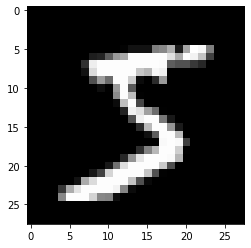

In [46]:
x_train, y_train, x_test, y_test = process_mnist_data()
img = x_train[0].reshape(28, 28, 1)
plt.imshow(img, cmap='gray')

In [47]:
model = parse_input_model()
mnist_batch_1 = x_train[0:32].reshape(32, 1, 28, 28)
mnist_labels_1 = y_train[0:32]
mnist_batch_1.shape

(32, 1, 28, 28)

In [48]:
# train
mnist_subsample_x = x_train[:4992]
mnist_subsample_y = y_train[:4992]
# validation
mnist_validation_x = x_test[:2000]
mnist_validation_y = y_test[:2000]
# test
mnist_test_x = x_test[5001:7001]
mnist_test_y = y_test[5001:7001]

In [49]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(0,10))

LabelBinarizer()

In [50]:
validation_batch = mnist_validation_x.reshape(2000, 1, 28, 28)
validation_labels = label_binarizer.transform(mnist_validation_y)

In [51]:
validation_labels[0:100]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0,

In [52]:
test_batch = mnist_test_x.reshape(2000, 1, 28, 28)
test_labels = label_binarizer.transform(mnist_test_y)

In [53]:
test_labels[0:100]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0,

In [54]:
def measure_accuracy(y_true, y_pred):
    accurate = np.sum(np.all(y_true == y_pred, axis=1))
    total = y_true.shape[0]
    return accurate / total

In [55]:
def predict_labels(a):
    return (a == a.max(axis=1)[:,None]).astype(int)

In [56]:
# inp = mnist_batch_1
# for layer in model:
#     inp = layer.forward(inp)
#
# labels_true = label_binarizer.transform(mnist_labels_1)
# l = loss_function(labels_true, inp)
#
# out = labels_true
# for layer in reversed(model):
#     out = layer.backward(out)

In [57]:
# for i in range(10):
#     losses = []
#     index = [i for i in range(1,157)]
#     for j in range(0, 4992, 32):
#         batch_x = mnist_subsample_x[j:j+32].reshape(32, 1, 28, 28)
#         batch_y = mnist_subsample_y[j:j+32]
#         model_out = batch_x
#         # train
#         for layer in model:
#             # print(layer)
#             model_out = layer.forward(model_out)
#             # print(model_out.shape)
#
#         true_labels = label_binarizer.transform(batch_y)
#         l = loss_function(true_labels, model_out)
#         losses.append(l)
#         # print("Epoc {} batch {} loss = {}".format(i, j//32, l))
#
#
#
#         model_back = true_labels
#         for layer in reversed(model):
#             # print(layer)
#             model_back = layer.backward(model_back)
#             # print(model_back.shape)
#
#     plt.plot(index, losses)
#     plt.show()
#
#     #validation
#     # validation_out = validation_batch
#     # for layer in model:
#     #     validation_out = layer.forward(validation_out)
#     # validation_loss = loss_function(validation_labels, validation_out)
#     # print('Validation loss after epoc {} is {}'.format(i, validation_loss))
#     # validation_predictions = predict_labels(validation_out)
#     # accuracy = measure_accuracy(validation_labels, validation_predictions)
#     # print('Validation accuracy after epoc {} is {}'.format(i, accuracy))